In [1]:
import libsbml
import networkx as nx
from utils import functions
from utils import graph_functions
from utils import complete_tests
import random
import roadrunner
import pickle
import os
from copy import deepcopy
from collections import defaultdict

In [5]:
results_path = '../../../results/real_dataset/large_class/results'
results_file = open(results_path, 'rb')
partial_results = pickle.load(results_file)
results_file.close()
partial_results

{'total_species': 2626,
 'uncertain_species': 35,
 'correct_species': 1873,
 'true_positives': 907,
 'false_positives': 408,
 'false_negatives': 345,
 'true_negatives': 966}

In [2]:
description = {
    'species': [],
    'reactions': [],
    'connections': [],
    'altered': ''
}

In [3]:
def convert_sbml_to_network(file_path):
    
    reader = libsbml.SBMLReader()
    document = reader.readSBML(file_path)
    if document.getNumErrors() > 0:
        print("Errors occurred while loading the SBML file.")
    model = document.getModel()
    
    num_reactions = model.getNumReactions()
    num_species = model.getNumSpecies()
    
    print('number reactions', model.getNumReactions())
    print('number species', model.getNumSpecies()) 
    
    for i in range(num_species):
        description['species'].append(model.getSpecies(i).getId())
    
    for i in range(num_reactions):
        description['reactions'].append([model.getReaction(i).getId(), 0, 1])
        num_reactants = model.getReaction(i).getNumReactants()
        num_products = model.getReaction(i).getNumProducts()
        
        num_parameters = model.getReaction(i).getKineticLaw().getNumParameters()
        is_reversible = False
        if num_parameters == 2:
            is_reversible = True
            
        if is_reversible:
            description['reactions'].append([str(model.getReaction(i).getId() + 'revert'), 0, 1])
        
        for j in range(num_reactants):
            reactant = model.getReaction(i).getReactant(j).getSpecies()
            description['connections'].append([reactant, model.getReaction(i).getId()])
            if is_reversible:
                description['connections'].append([str(model.getReaction(i).getId() + 'revert'), reactant])
            
        for k in range(num_products):
            product = model.getReaction(i).getProduct(k).getSpecies()
            description['connections'].append([model.getReaction(i).getId(), product])
            if is_reversible:
                description['connections'].append([product, str(model.getReaction(i).getId() + 'revert')])

In [4]:
convert_sbml_to_network('BIOMD0000000052.xml')

number reactions 11
number species 11


In [5]:
description['reactions']

[['_J1', 0, 1],
 ['_J2', 0, 1],
 ['_J3', 0, 1],
 ['_J4', 0, 1],
 ['_J5', 0, 1],
 ['_J6', 0, 1],
 ['_J7', 0, 1],
 ['_J8', 0, 1],
 ['_J9', 0, 1],
 ['_J10', 0, 1],
 ['_J11', 0, 1]]

In [5]:
def alter_pathway(filename, reaction_number, parameter_number, output_filename):
    reader = libsbml.SBMLReader()
    document = reader.readSBML(filename)
    model = document.getModel()
    
    reaction = model.getReaction(reaction_number)
    kinetic_law = reaction.getKineticLaw()
    parameter = kinetic_law.getParameter(parameter_number)
    parameter.setValue(parameter.getValue() * 100)
    
    modified_sbml = libsbml.writeSBML(document, output_filename)

In [6]:
def generate_test_set(filename, description):
    reader = libsbml.SBMLReader()
    document = reader.readSBML(filename)
    model = document.getModel()
    base_dir = 'altered_pathways2'
    
    i = 0
    num_reactions = model.getNumReactions()
    for j in range(num_reactions):
        reaction = model.getReaction(j)
        kinetic_law = reaction.getKineticLaw()
        num_parameters = kinetic_law.getNumParameters()
        for k in range(num_parameters):
            parameter = kinetic_law.getParameter(k)
            os.makedirs(os.path.join(base_dir, 'reaction' + str(i)), exist_ok=True)
            alteration_dir = os.path.join(base_dir, 'reaction' + str(i), 'reaction_' + str(i) + '_100x.xml')
            alter_pathway('BIOMD0000000052.xml', j, k, alteration_dir)
            
            altered_description = deepcopy(description)
            altered_description['altered'] = altered_description['reactions'][i][0]
            description_dir = os.path.join(base_dir, 'reaction' + str(i), 'description')
            description_file = open(description_dir, 'wb')
            pickle.dump(altered_description, description_file)
            description_file.close()
            i += 1

In [7]:
generate_test_set('BIOMD0000000052.xml', description)

In [2]:
total_species = 0
uncertain_species = 0
correct_species = 0
true_positives = 0
false_positives = 0
false_negatives = 0
true_negatives = 0 
deltas_normal = []
deltas_uncertain = []

complete_results = defaultdict()
for directory in list(os.listdir('altered_pathways2')):
    if directory == '.DS_Store':
        continue
    dir = os.path.join('altered_pathways2', directory)
    files = os.listdir(dir)
    description_index = 0
    altered_file_index = 0
    
    for i in range(len(files)):
        if files[i] == 'description':
            description_index = i
        elif files[i] != 'description' and files[i] != 'results':
            altered_file_index = i
            
    res = complete_tests.complete_tests2(
            'BIOMD0000000052.xml',
            os.path.join(dir, files[altered_file_index]),
            os.path.join(dir, 'description'),
            []
        )
    
    '''complete_results_path = os.path.join(dir, 'results')
    complete_results_file = open(complete_results_path, 'wb')
    pickle.dump(res, complete_results_file)
    complete_results_file.close()'''
        
    insights, all, uncertain, d_normal, d_uncertain = complete_tests.get_insights_confidence_intervals('altered', res, 1, detailed_classification=False, threshold=0, ignore_uncertain=False)
    
    total_species += all
    uncertain_species += uncertain
    
    for d in d_normal:
        deltas_normal.append(d)
    for d in d_uncertain:
        deltas_uncertain.append(d)
        
    total_count = 0
    correct_count = 0
    for specie in insights.keys():
        
        if insights[specie][0] == 0 or insights[specie][1][1] == 0.5:
            continue
        
        total_count += 1
        if insights[specie][0] == insights[specie][1][0]:
            correct_count += 1
            correct_species += 1
        
        if insights[specie][1][0] == insights[specie][0] == 1:
            true_positives += 1
        elif insights[specie][1][0] == insights[specie][0] == -1:
            true_negatives += 1
        elif insights[specie][1][0] == 1 and insights[specie][0] == -1:
            false_positives += 1
        elif insights[specie][1][0] == -1 and insights[specie][0] == 1:
            false_negatives += 1
        
        
         
    print(directory, ' total species: ', total_count, 'correct species: ', correct_count, 'ratio: ', correct_count/total_count)
    complete_results[directory] = correct_count / total_count
    

Converged at time 5895.0
Min and max abs differences:  7.30682369971376e-16 0.0001676502406903202
Specie:  Glu expected result:  increased  normal final:  1.0302124382941365e-10  altered final:  0.2716607656790211
confidence interval:  [0.9390261185268788, 0.9463043008500015]
deltas coming from simulation:  [0.27166076557599983, 0]
Specie:  Fru expected result:  increased  normal final:  1.185364964191579e-10  altered final:  0.005258600026267332
confidence interval:  [0.11903387936607959, 0.12851504805959965]
deltas coming from simulation:  [0.005258599907730835, 0]
Specie:  Formic_acid expected result:  increased  normal final:  27.07563479897424  altered final:  104.2108132612314
confidence interval:  [0.5367958015531841, 0.62257003637023]
deltas coming from simulation:  [77.13517846225716, 0]
Specie:  Triose expected result:  increased  normal final:  2.2783468006312738e-08  altered final:  0.01984782223794092
confidence interval:  [0.19460210112933712, 0.21271846998803437]
deltas 

In [3]:
import numpy as np
scores = []
for experiment in complete_results.keys():
    scores.append(complete_results[experiment])
print('Average score: ', np.average(scores))

Average score:  0.7148760330578512


In [4]:
print('total: ', total_species, ' correct: ', correct_species, ' uncertain: ', uncertain_species, ' true pos: ', true_positives, ' true neg: ', true_negatives, ' false_pos: ', false_positives, 'false neg: ', false_negatives,)

total:  104  correct:  74  uncertain:  5  true pos:  30  true neg:  44  false_pos:  16 false neg:  14


In [6]:
partial_results['total_species'] += total_species
partial_results['uncertain_species'] += uncertain_species
partial_results['correct_species'] += correct_species
partial_results['true_positives'] += true_positives
partial_results['false_positives'] += false_positives
partial_results['true_negatives'] += true_negatives
partial_results['false_negatives'] += false_negatives

In [7]:
results_path = '../../../results/real_dataset/large_class/results'
results_file = open(results_path, 'wb')
pickle.dump(partial_results, results_file)
results_file.close()

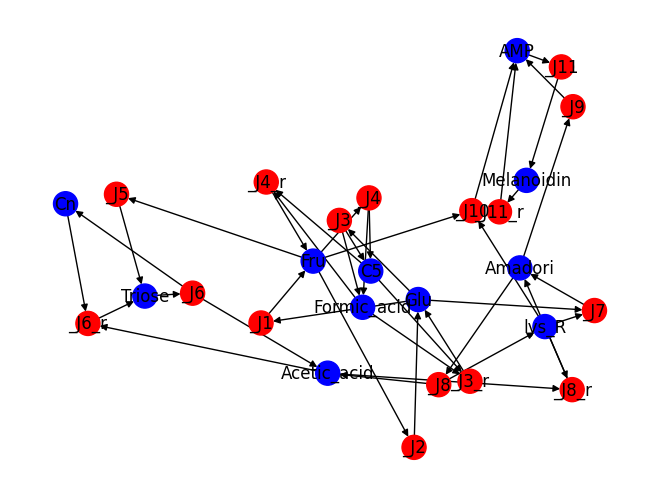

In [33]:
graph = functions.generate_graph(description)
functions.plot_graph(graph)

In [16]:
res_path = 'altered_pathways/reaction8/results'
desc_path = 'altered_pathways/reaction8/description'
res_file = open(res_path, 'rb')
desc_file = open(desc_path, 'rb')
r = pickle.load(res_file)
description = pickle.load(desc_file)
desc_file.close()
res_file.close()
print(description['altered'])
true_negatives = 0
true_positives = 0
false_positives = 0
false_negatives = 0
insights, all, uncertain, d_normal, d_uncertain = complete_tests.get_insights_confidence_intervals('altered', r, 1, detailed_classification=True, threshold=0, ignore_uncertain=False)

total_species = 0
uncertain_species = 0
correct_species = 0
total_species += all
uncertain_species += uncertain
        
total_count = 0
correct_count = 0
for specie in insights.keys():
        
    if insights[specie][0] == 0 or insights[specie][1][1] == 0.5:
        continue
        
    total_count += 1
    if insights[specie][0] == insights[specie][1][0]:
        correct_count += 1
        correct_species += 1
        
    if insights[specie][1][0] == insights[specie][0] == 1:
        true_positives += 1
    elif insights[specie][1][0] == insights[specie][0] == -1:
        true_negatives += 1
    elif insights[specie][1][0] == 1 and insights[specie][0] == -1:
        false_positives += 1
    elif insights[specie][1][0] == -1 and insights[specie][0] == 1:
        false_negatives += 1
        
        
         
print( ' total species: ', total_count, 'correct species: ', correct_count, 'ratio: ', correct_count/total_count)

_J9
Specie:  Glu expected result:  increased  normal final:  0.7676750123746309  altered final:  0.8424302118863971
confidence interval:  [0.5842647204943047, 0.5920616903153539]
deltas coming from simulation:  [0.07475519951176623, 4.549727882862257e-05]
Specie:  Fru expected result:  increased  normal final:  0.8833109020314652  altered final:  0.9689921625639625
confidence interval:  [0.5675343157588947, 0.5737945817411978]
deltas coming from simulation:  [0.08568126053249725, 0.0009700011664686237]
Specie:  Formic_acid expected result:  increased  normal final:  26.78887961444032  altered final:  28.0646434605695
confidence interval:  [0.6604438280960206, 0.6826037694886333]
deltas coming from simulation:  [1.2757638461291805, 0.000476228892171171]
Specie:  Triose expected result:  increased  normal final:  13.40935336325101  altered final:  14.399439406839448
confidence interval:  [0.5404822673360135, 0.5463420340716859]
deltas coming from simulation:  [0.9900860435884393, 0.00073

In [34]:
description_path = 'reversible_low_constants/description_J1_altered'
description_file = open(description_path, 'wb')
pickle.dump(description, description_file)
description_file.close()

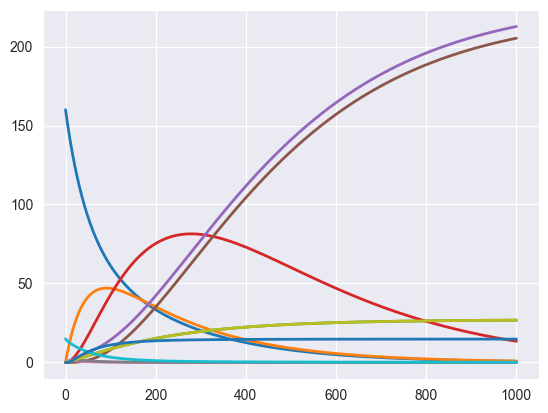

       time,    [Glu],    [Fru], [Formic_acid],  [Triose], [Acetic_acid],        [Cn],   [Amadori],       [AMP],      [C5],  [lys_R], [Melanoidin]
 [[       0,      160,        0,             0,         0,             0,           0,           0,           0,         0,       15,            0],
  [   1.001,  157.914,   1.5788,     0.0756562, 0.0112896,     0.0218813, 1.65827e-05,    0.373642,   0.0287115, 0.0756562,  14.5964,   0.00124037],
  [   2.002,  155.875,   3.1129,      0.152056, 0.0446653,     0.0797705, 0.000131573,    0.648874,    0.100554,  0.152056,  14.2416,   0.00898519],
  [   3.003,  153.878,  4.60357,      0.229171, 0.0994036,      0.164168, 0.000440428,    0.849263,    0.198622,  0.229171,  13.9246,    0.0275206],
  [   4.004,  151.923,  6.05202,      0.306975,  0.174802,       0.26787,  0.00103547,     0.99278,    0.310809,  0.306975,  13.6371,    0.0593305],
  [ 5.00501,  150.008,   7.4594,      0.385441,  0.270177,      0.385428,  0.00200598,     1.09314,    0.428

In [5]:
final_concentrations_normal = functions.plot_simulation_complete('BIOMD0000000052.xml')

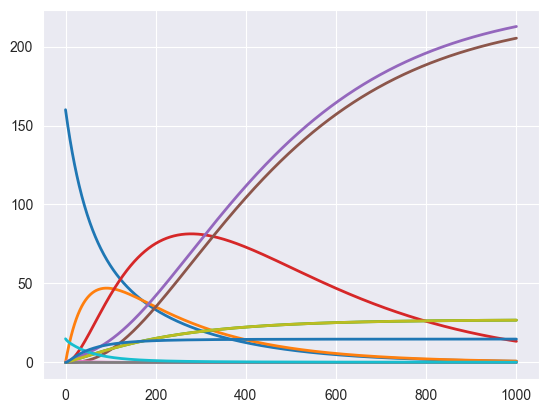

       time,    [Glu],    [Fru], [Formic_acid],  [Triose], [Acetic_acid],        [Cn],   [Amadori],       [AMP],      [C5],  [lys_R], [Melanoidin]
 [[       0,      160,        0,             0,         0,             0,           0,           0,           0,         0,       15,            0],
  [   1.001,  157.914,   1.5788,     0.0756562, 0.0112896,     0.0218814, 1.65827e-05,    0.373642, 4.56321e-06, 0.0756562,  14.5964,    0.0299473],
  [   2.002,  155.875,   3.1129,      0.152056, 0.0446653,     0.0797705, 0.000131573,    0.648874, 7.97657e-06,  0.152056,  14.2416,     0.109531],
  [   3.003,  153.878,  4.60357,      0.229171, 0.0994036,      0.164168, 0.000440428,    0.849262, 1.05129e-05,  0.229171,  13.9246,     0.226132],
  [   4.004,  151.923,  6.05202,      0.306975,  0.174802,       0.26787,  0.00103547,     0.99278, 1.23806e-05,  0.306975,  13.6371,     0.370128],
  [ 5.00501,  150.008,   7.4594,      0.385441,  0.270177,      0.385428,  0.00200598,     1.09314, 1.37386e

In [12]:
final_concentrations_altered = functions.plot_simulation_complete('altered_pathways/reaction10/reaction_10_100x.xml')

In [13]:
species = description['species']
species

['Glu',
 'Fru',
 'Formic_acid',
 'Triose',
 'Acetic_acid',
 'Cn',
 'Amadori',
 'AMP',
 'C5',
 'lys_R',
 'Melanoidin']

In [14]:
final_normal = final_concentrations_normal[0][-1]
final_altered = final_concentrations_altered[0][-1]

In [15]:
final_normal

[1.00000000e+03 7.67675012e-01 8.83310902e-01 2.67888796e+01
 1.34093534e+01 2.12685947e+02 2.05279795e+02 1.05315935e-04
 3.35695076e-04 2.67888796e+01 1.90591886e-01 1.48089671e+01]

In [16]:
temp = final_concentrations_normal[1]
temp

[160.   0.   0.   0.   0.   0.   0.   0.   0.  15.   0.]

In [17]:
import math
expected_results = {}
for i in range(len(species)):
    delta1 = 0
    delta2 = 0
    print(species[i])
    if final_normal[i + 1] != 0:
        if temp[i] != 0:
            initial_concentration = temp[i]
            delta1 = math.fabs((final_altered[i + 1] - final_normal[i + 1]) / initial_concentration)
            delta2 = math.fabs(1 - (final_altered[i + 1] / final_normal[i + 1]))
            paired_delta = delta1 * delta2
        else:
            delta2 = math.fabs(1 - (final_altered[i + 1] / final_normal[i + 1]))
            paired_delta = delta2 / 100
            
        relative_delta = (final_altered[i + 1] - final_normal[i + 1]) / final_normal[i + 1]
        
    else: 
        relative_delta = 0
        
    if paired_delta >= 0.01 and final_altered[i + 1] < final_normal[i + 1]:
        expected_results[species[i]] = 'decreased'
    elif paired_delta >= 0.01 and final_altered[i + 1] > final_normal[i + 1]:
        expected_results[species[i]] = 'increased'
    else:
        expected_results[species[i]] = 'unchanged'
    
    print('final normal: ', final_normal[i + 1], 'final altered: ', final_altered[i + 1], 'delta: ', final_altered[i + 1] - final_normal[i + 1], 'relative delta ', relative_delta, 'initial concentration: ', temp[i], 'delta1', delta1, 'delta2', paired_delta)

Glu
final normal:  0.7676750123746309 final altered:  0.7676759531664613 delta:  9.407918304393803e-07 relative delta  1.2255079496846606e-06 initial concentration:  160.0 delta1 5.879948940246127e-09 delta2 7.205924170612865e-15
Fru
final normal:  0.8833109020314652 final altered:  0.8833119795301523 delta:  1.077498687052092e-06 relative delta  1.2198408109466641e-06 initial concentration:  0.0 delta1 0 delta2 1.2198408110286607e-08
Formic_acid
final normal:  26.78887961444032 final altered:  26.788879552601426 delta:  -6.183889311728308e-08 relative delta  -2.308379223293435e-09 initial concentration:  0.0 delta1 0 delta2 2.3083792655143044e-11
Triose
final normal:  13.40935336325101 final altered:  13.40934748759107 delta:  -5.875659939036382e-06 relative delta  -4.3817623265406043e-07 initial concentration:  0.0 delta1 0 delta2 4.381762326310934e-09
Acetic_acid
final normal:  212.68594706285512 final altered:  212.68595037722477 delta:  3.3143696498427744e-06 relative delta  1.558

In [33]:
expected_results

{'Glu': 'decreased',
 'Fru': 'unchanged',
 'Formic_acid': 'unchanged',
 'Triose': 'unchanged',
 'Acetic_acid': 'unchanged',
 'Cn': 'unchanged',
 'Amadori': 'increased',
 'AMP': 'unchanged',
 'C5': 'unchanged',
 'lys_R': 'increased',
 'Melanoidin': 'unchanged'}

In [14]:
description['reactions'][0][1] = 0.2

In [15]:
for i in range(len(description['reactions'])):
    description['reactions'][i][2] = random.uniform(0, 1)

In [16]:
description['altered'] = '_J1'

In [17]:
graph = graph_functions.generate_graph(description)

In [18]:
species_propagation = []
for i in range(100):
    print("ITERATION ", i)
    species_propagation.append(graph_functions.update_graph(graph, 1, i + 1))

ITERATION  0
---values before iteration---
{'Glu': 0.5, 'Fru': 0.5, 'Formic_acid': 0.5, 'Triose': 0.5, 'Acetic_acid': 0.5, 'Cn': 0.5, 'Amadori': 0.5, 'AMP': 0.5, 'C5': 0.5, 'lys_R': 0.5, 'Melanoidin': 0.5}
Firing reaction  _J1
reactant:  Glu  delta:  0.0
{'type': 'reaction', 'strength': 0.2, 'weight': 0.14717645696399007}
new reaction strength:  0.0  reaction weight:  0.14717645696399007  reaction strength  0.2
reactant:  Glu  new value:  0.31002551887238755  delta:  -0.18997448112761245
product:  Fru new value:  0.6899744811276125
Firing reaction  _J2
reactant:  Fru  delta:  0.0
{'type': 'reaction', 'strength': 0, 'weight': 0.5589296016720304}
new reaction strength:  0.0  reaction weight:  0.5589296016720304  reaction strength  0.0
reactant:  Fru  new value:  0.5  delta:  0.0
product:  Glu new value:  0.5
Firing reaction  _J3
reactant:  Glu  delta:  0.0
{'type': 'reaction', 'strength': 0, 'weight': 0.6708728018280298}
new reaction strength:  0.0  reaction weight:  0.6708728018280298  

In [47]:
species_propagation

[{'Glu': 0.31002551887238755,
  'Fru': 0.6899744811276125,
  'Formic_acid': 0.5,
  'Triose': 0.5,
  'Acetic_acid': 0.5,
  'Cn': 0.5,
  'Amadori': 0.5,
  'AMP': 0.5,
  'C5': 0.5,
  'lys_R': 0.5,
  'Melanoidin': 0.5},
 {'Glu': 0.43531505674304616,
  'Fru': 0.5561963454597392,
  'Formic_acid': 0.46724531354611,
  'Triose': 0.7340266498538937,
  'Acetic_acid': 0.5,
  'Cn': 0.5,
  'Amadori': 0.3991229947343584,
  'AMP': 0.6133872030728014,
  'C5': 0.46724531354611,
  'lys_R': 0.49374490109642005,
  'Melanoidin': 0.5},
 {'Glu': 0.44583238094735494,
  'Fru': 0.53010775446057,
  'Formic_acid': 0.47807712880656467,
  'Triose': 0.6411264539707413,
  'Acetic_acid': 0.5603821739804824,
  'Cn': 0.8038524045377534,
  'Amadori': 0.45326314515192945,
  'AMP': 0.5574114027928161,
  'C5': 0.47807712880656467,
  'lys_R': 0.46526217284337407,
  'Melanoidin': 0.6235666991054962},
 {'Glu': 0.4477699357671864,
  'Fru': 0.5296585626352822,
  'Formic_acid': 0.48009085417283903,
  'Triose': 0.6451644584126865,


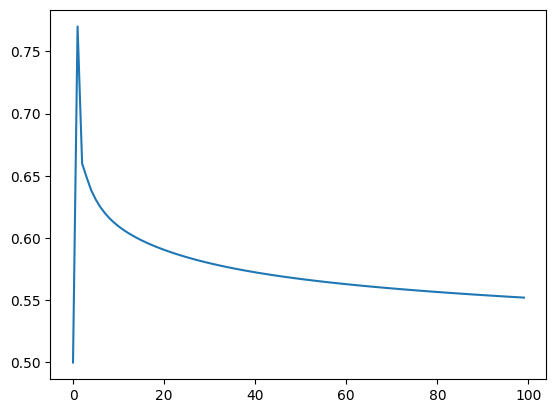

In [19]:
import matplotlib.pyplot as plt
concentrations = [conc['Triose'] for conc in species_propagation]
concentrations
plt.plot(concentrations[0:500])

In [20]:
final_propagation = species_propagation[-1]
for s in final_propagation.keys():
    print(s, 'propagation results: ', final_propagation[s], 'simulation results: ', expected_results[s])

Glu propagation results:  0.49201165508929684 simulation results:  decreased
Fru propagation results:  0.5023067632949593 simulation results:  unchanged
Formic_acid propagation results:  0.4972358698007513 simulation results:  unchanged
Triose propagation results:  0.5521247775227113 simulation results:  unchanged
Acetic_acid propagation results:  0.5004099468177675 simulation results:  unchanged
Cn propagation results:  0.6046912060310494 simulation results:  unchanged
Amadori propagation results:  0.4983928315833834 simulation results:  increased
AMP propagation results:  0.5216698441497145 simulation results:  unchanged
C5 propagation results:  0.4972358698007513 simulation results:  unchanged
lys_R propagation results:  0.5005445564408209 simulation results:  unchanged
Melanoidin propagation results:  0.5216575409943368 simulation results:  unchanged


In [3]:
functions.steady_state('reversible_normal_constants/BIOMD0000000052.xml')

RuntimeError: Maximum iterations exceeded

In [2]:
res = complete_tests.complete_tests2(
            'reversible_normal_constants/BIOMD0000000052.xml',
            'reversible_normal_constants/BIOMD0000000052_kf1_100x.xml',
            'reversible_low_constants/description_J1_altered',
            []
        )

In [3]:
insights = complete_tests.get_insights_confidence_intervals('altered', res, 1, detailed_classification=True, threshold=0, ignore_uncertain=False)

Specie:  Glu expected result:  decreased
confidence interval:  [0.055019861045666175, 0.061813630171570925]
deltas coming from simulation:  [-2.072206863012871, 0.012951170531732262]
Specie:  Fru expected result:  decreased
confidence interval:  [0.8669389419389228, 0.8763651544456541]
deltas coming from simulation:  [-2.029322796250257, 0.008843429769433746]
Specie:  Formic_acid expected result:  decreased
confidence interval:  [0.4837580334680096, 0.49080907395578255]
deltas coming from simulation:  [-0.546862364593281, 0.005487165062532309]
Specie:  Triose expected result:  increased
confidence interval:  [0.8187890897671877, 0.8401374797556019]
deltas coming from simulation:  [19.86595223028371, 0.0008874078751943105]
Specie:  Acetic_acid expected result:  decreased
confidence interval:  [0.4826554708117598, 0.49594943478016984]
deltas coming from simulation:  [-1.8964722213712477, 0.0003939665671469683]
Specie:  Cn expected result:  increased
confidence interval:  [0.7034400602479

In [40]:
insights[2]

defaultdict(<function utils.complete_tests.get_insigths.<locals>.<lambda>()>,
            {'Glu': [-1,
              0.4874021059683166,
              0.005566376931942822,
              0.46591995924936924,
              0.5024021661197458],
             'Fru': [-1,
              0.5104271338994066,
              0.003938338490198408,
              0.4990570817886646,
              0.5227940038000275],
             'Formic_acid': [-1,
              0.4990904180795772,
              0.006486546047706427,
              0.47146953098305666,
              0.5189595767836748],
             'Triose': [0,
              0.5891340152657999,
              0.02779493577794517,
              0.5148677057839087,
              0.6689603003287768],
             'Acetic_acid': [0,
              0.5102738196807152,
              0.018433652222878565,
              0.42902237531974663,
              0.5596873297997089],
             'Cn': [1,
              0.6545814521267114,
              0.0444384457

In [41]:
perfect_configurations = sorted(insights[0], key=lambda x: x[1])

In [44]:
perfect_configurations[1]

[[['_J1', 0.7528873339554121],
  ['_J2', -1.1540384467796878],
  ['_J3', -1.3242637636846184],
  ['_J3_r', -0.6904093857627013],
  ['_J4', -1.3270106031577475],
  ['_J4_r', -1.4821455693595857],
  ['_J5', -1.255866914361457],
  ['_J6', -0.8538179141841034],
  ['_J6_r', 1.1497540884185495],
  ['_J7', -0.4612444287875175],
  ['_J8', 1.3610248931495335],
  ['_J8_r', 0.9026823610318648],
  ['_J9', 1.2790442843055363],
  ['_J10', -1.131741024470141],
  ['_J11', 0.7671327040690032],
  ['_J11_r', 0.00777965431154426]],
 1]